In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Wed Mar 22 01:14:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   49C    P0    73W / 275W |  68261MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow, show 
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils
import json
import PIL
import logging
import sys
import getpass


sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/DiffusionSimple/util')

In [3]:
from loaders import generateDatasets, inOut, saveJSON, loadJSON#, MyData
from tools import accuracy, tools, per_image_error, predVsTarget, errInDSvsLat, errOverLat
from plotter import myPlots, plotSamp, plotSampRelative
from NNets import SimpleCNN, SimpleCNNConvT, SimpleCNN_L, SimpleCNN_S, UNet, LeakyUNet, SimpleCNNCat, \
SimpleCNNJules, UNetGPT, UNetBias0, UNetPrelu, SimpleCNNJulesPB, UNetPB


def select_nn(arg, d=None, num_samples=1):
    if arg == "SimpleCNN":
        class DiffSur(SimpleCNN):
            pass 
    elif arg == "UNet":
        class DiffSur(UNet):
            pass
    elif arg == "SimpleCNNConvT":
        class DiffSur(SimpleCNNConvT):
            pass
    elif arg == "SimpleCNN_L":
        class DiffSur(SimpleCNN_L):
            pass
    elif arg == "SimpleCNN_S":
        class DiffSur(SimpleCNN_S):
            pass
    elif arg == "LeakyUNet":
        class DiffSur(LeakyUNet):
            pass
    elif arg == "SimpleCNNCat":
        class DiffSur(SimpleCNNCat):
            pass
    elif arg == "SimpleCNNJules":
        class DiffSur(SimpleCNNJules):
            pass
    elif arg == "SimpleCNNReflect":
        class DiffSur(SimpleCNNReflect):
            pass
    elif arg == "UNetGPT":
        class DiffSur(UNetGPT):
            pass
    elif arg == "UNetBias0":
        class DiffSur(UNetBias0):
            pass
    elif arg == "UNetPrelu":
        class DiffSur(UNetPrelu):
            pass
    elif arg == "SimpleCNNJulesPB":
        class DiffSur(SimpleCNNJulesPB):
            pass
    elif arg == "UNetPB":
        class DiffSur(UNetPB):
            pass
    return DiffSur()

In [4]:
###Start Here
PATH = '/home/' + getpass.getuser() +'/Projects/DiffusionSimple/Results/' #"/raid/javier/Datasets/DiffusionSimple/"
DATASETNAME = "Datav2"

BATCH_SIZE=50
NUM_WORKERS=8
ngpu = 1
lr = 0.0001
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

trainloader, testloader = generateDatasets(PATH, datasetName=DATASETNAME, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, s=256, transformation="linear").getDataLoaders()
# dict = inOut().newDict(PATH, dir)
modelNames = os.listdir(os.path.join(PATH, "Dict"))
modelNames.sort()


/home/javier/miniconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [5]:
r = next(iter(testloader))

In [22]:
# r[1].shape
# plt.imshow(r[1][0,0,:,:])
dir = 'modelUNetPB_4'
# dir = 'model_4'
os.listdir(os.path.join(PATH, "Dict", dir))[0]
dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))

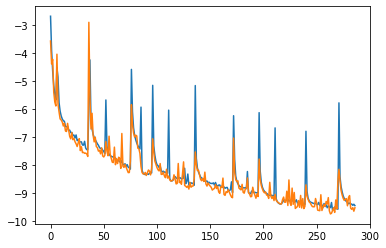

In [23]:
# dir = 'model0'
# os.listdir(os.path.join(PATH, "Dict", dir))[0]
# dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
plt.plot(np.log(dict['Loss']))
plt.plot(np.log(dict['LossTest']))
# plt.yscale('log')

In [25]:
modelNames

7.39162568193437e-05

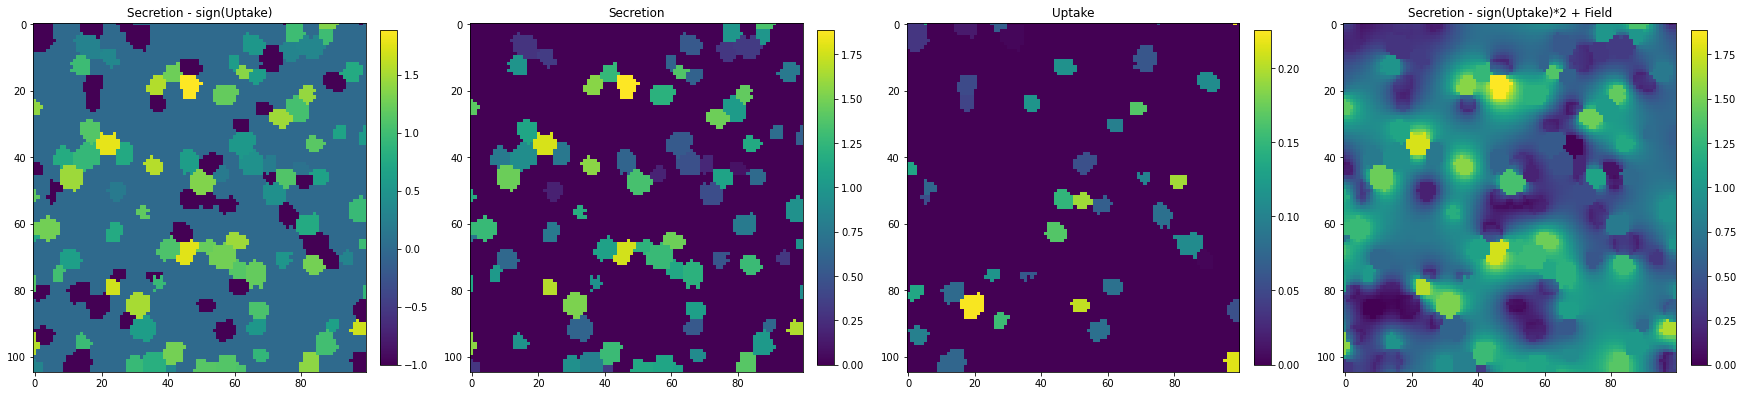

In [9]:
# plt.imshow( np.sign(r[0][0,0,:,:].numpy()))
fig, axs = plt.subplots(1,4, figsize=(30, 50))
axs[0].set_title('Secretion - sign(Uptake)')
im = axs[0].imshow(r[0][1,1,150:-1,130:230].numpy() - np.sign(r[0][1,0,150:-1,130:230].numpy()))
fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

axs[1].set_title('Secretion')
im = axs[1].imshow(r[0][1,1,150:-1,130:230].numpy() )
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[2].set_title('Uptake')
im = axs[2].imshow(r[0][1,0,150:-1,130:230].numpy())
fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

axs[3].set_title('Secretion - sign(Uptake)*2 + Field')
# im = axs[3].imshow(r[0][1,1,:,:].numpy() - np.sign(r[0][1,0,:,:].numpy())*2 + r[1][1,0,:,:].numpy())
im = axs[3].imshow(r[1][1,0,150:-1,130:230].numpy())
fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)

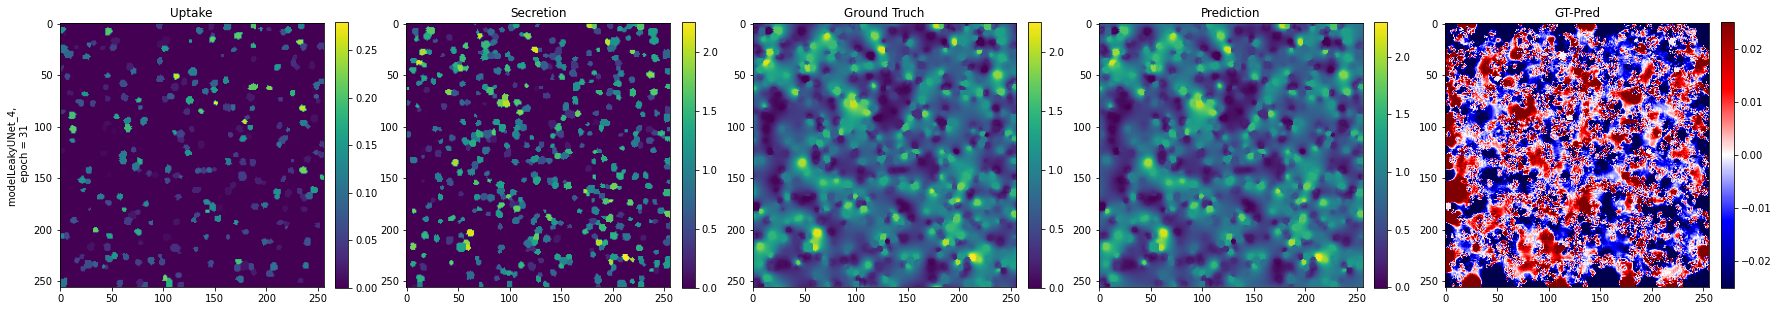

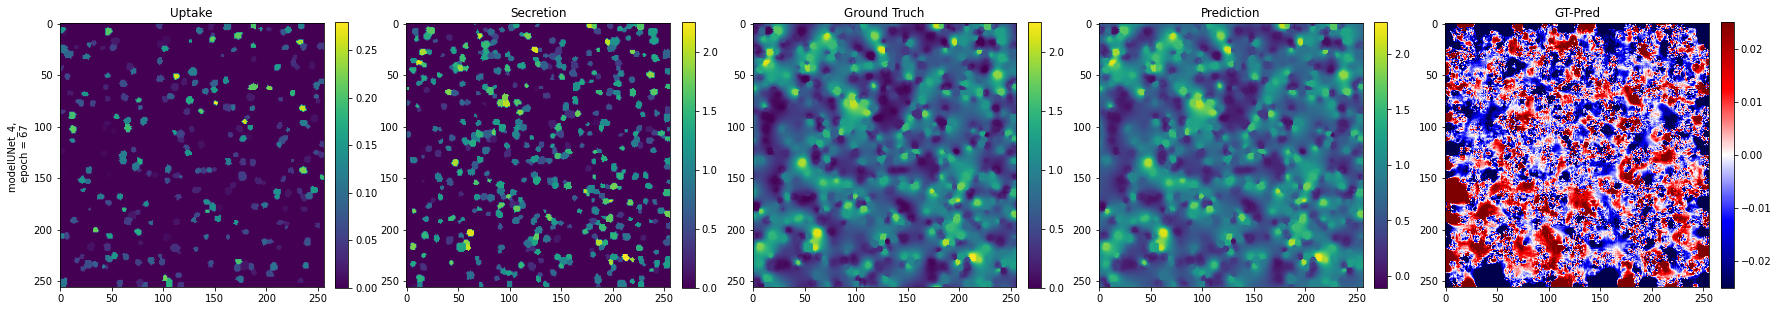

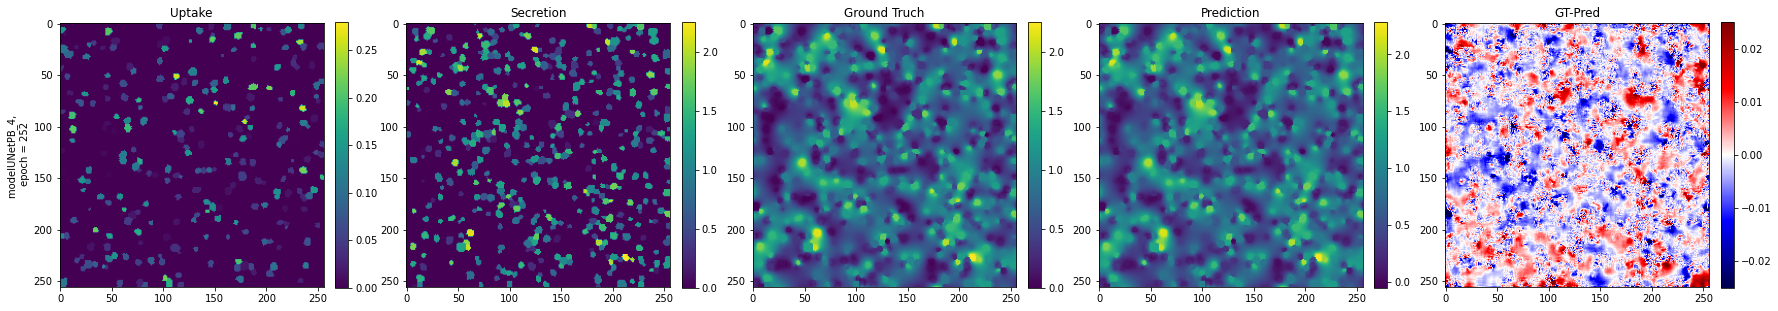

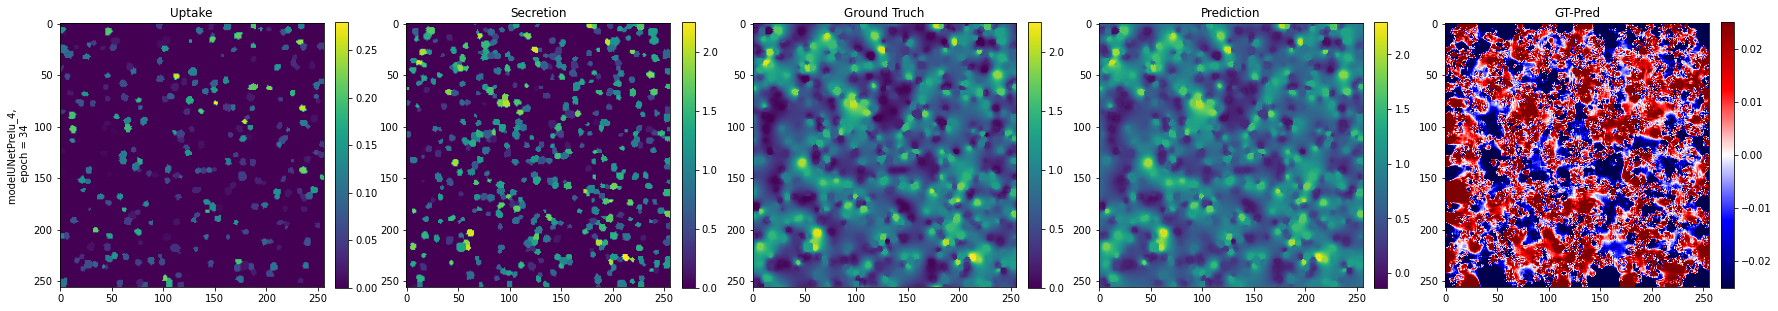

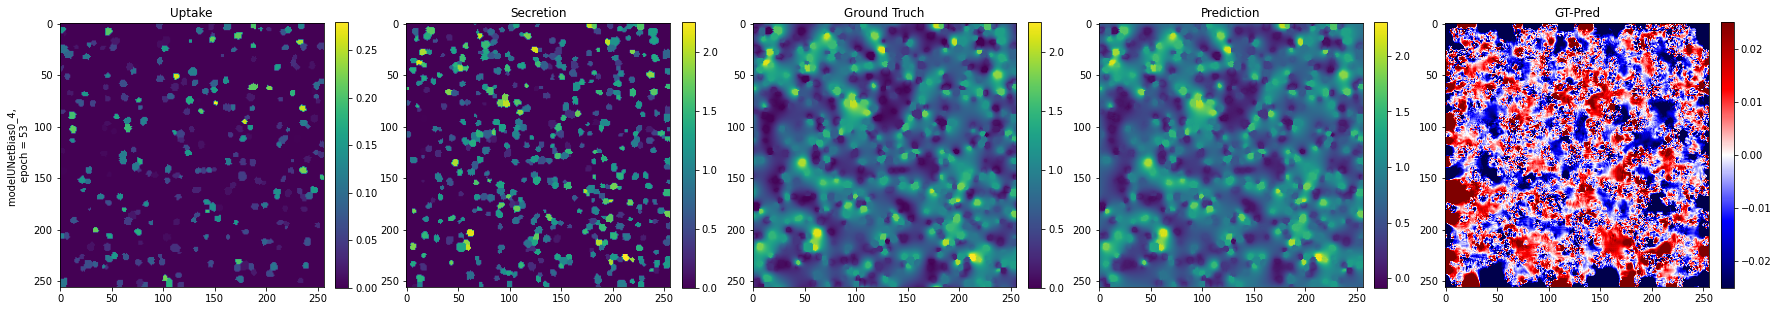

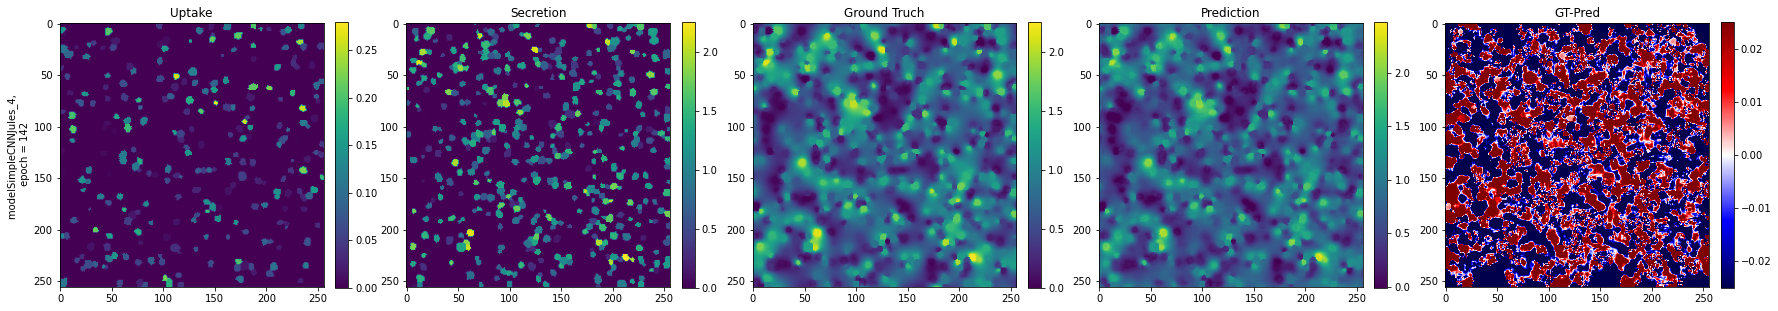

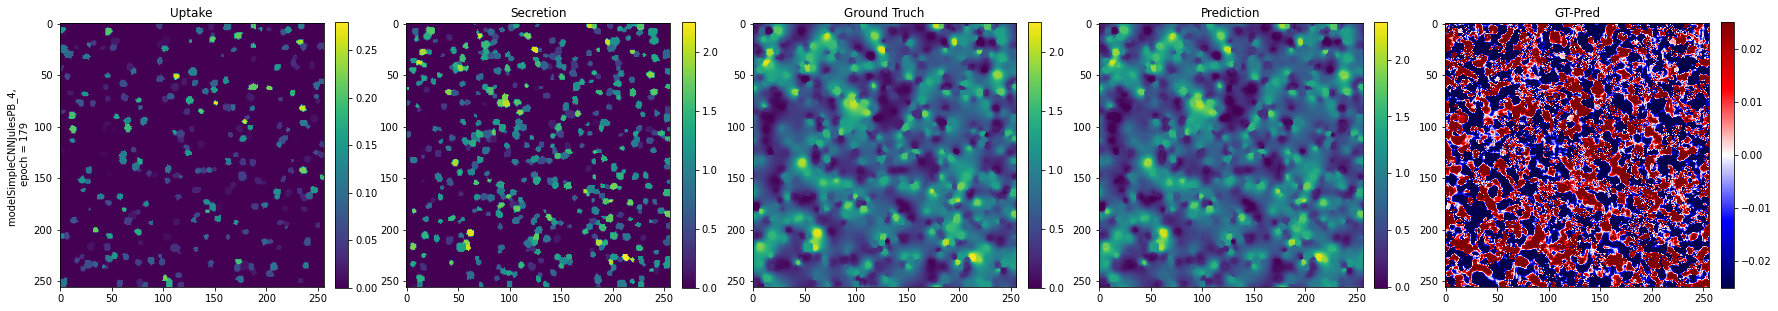

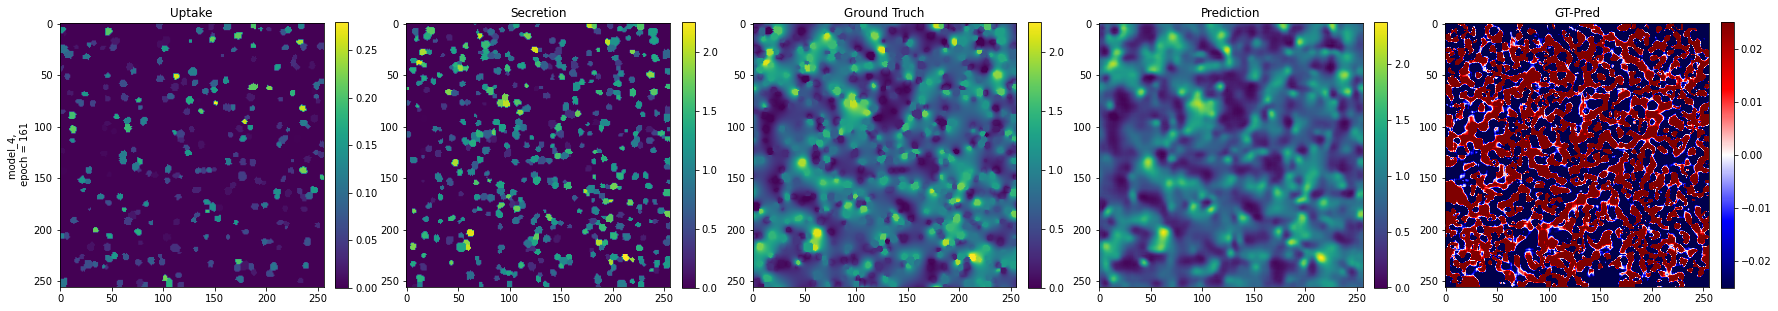

In [19]:
# for name in modelNames:
# for name in ['modelLeakyUNet_4', 'modelSimpleCNN-L_4', 'modelSimpleCNN-S_4', 'modelSimpleCNNCat_4', 'modelSimpleCNNConvT_4', 'modelSimpleCNNJules_4', 'modelSimpleCNNReflect_4', 'modelUNet_4', 'model_4', 'modelUNetPrelu_4', 'modelUNetBias0_4']:
for name in ['modelLeakyUNet_4', 'modelUNet_4', 'modelUNetPB_4', 'modelUNetPrelu_4', 'modelUNetBias0_4', 'modelSimpleCNNJules_4', 'modelSimpleCNNJulesPB_4', 'model_4']:
#     try:
        dir = name
        os.listdir(os.path.join(PATH, "Dict", dir))[0]
        dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
        
        diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
        diffSolv = diffSolv.to(device)
        lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict, tag='Best')
        
        yhat = diffSolv(r[0].to(device))

        fig, axs = plt.subplots(1,5, figsize=(30, 20))
        axs[0].set_title('Uptake')
        im = axs[0].imshow(r[0][1,0,:,:].numpy())
        axs[0].set_ylabel(f'{name}, \n epoch = {lastEpoch}')
        fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

        axs[1].set_title('Secretion')
        im = axs[1].imshow(r[0][1,1,:,:].numpy())
        fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
#         axs[1].axis('off')
            
        axs[2].set_title('Ground Truch')
        im = axs[2].imshow(r[1][1,0,:,:].numpy())
        fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
#         axs[2].axis('off')
        
        axs[3].set_title('Prediction')
        im = axs[3].imshow(yhat[1,0,:,:].detach().cpu().numpy())
        fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)
#         axs[3].axis('off')
        
        axs[4].set_title('GT-Pred')
        im = axs[4].imshow(r[1][1,0,:,:].numpy() - yhat[1,0,:,:].detach().cpu().numpy(), vmin=-0.025, vmax=0.025, cmap='seismic')
        fig.colorbar(im, ax=axs[4], fraction=0.046, pad=0.04)
#         axs[4].axis('off')

#         axs[5].set_title('min(1, abs(GT-Pred)/GT)')
#         im = axs[5].imshow( np.minimum(1, np.abs(r[1][1,0,:,:].numpy() - yhat[1,0,:,:].detach().cpu().numpy())/(r[1][1,0,:,:].numpy()+1e-6)) )
#         fig.colorbar(im, ax=axs[5], fraction=0.046, pad=0.04, format='%.0e')
        
#         axs[6].set_title('GT-Pred)/GT')
#         im = axs[6].imshow( (r[1][1,0,:,:].numpy() - yhat[1,0,:,:].detach().cpu().numpy()) * ( (1+r[1][1,0,:,:].max()) * torch.ones_like(r[1][1,0,:,:]) - r[1][1,0,:,:]).numpy() )
#         fig.colorbar(im, ax=axs[6], fraction=0.046, pad=0.04, format='%.0e')
        
        plt.savefig(PATH + f'Figs/{name}.png')
#     except:
#         pass

In [16]:
# for name in modelNames:
#     try:
#         dir = name
#         os.listdir(os.path.join(PATH, "Dict", dir))[0]
#         dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
        
#         diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
#         diffSolv = diffSolv.to(device)
#         lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict)
        
#         yhat = diffSolv(r[0].to(device))

#         fig, axs = plt.subplots(1,5, figsize=(30, 20))
#         axs[0].set_title('Uptake')
#         im = axs[0].imshow(r[0][0,0,:,:].numpy())
#         axs[0].set_ylabel(f'{name}, \n epoch = {lastEpoch}')
#         fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

#         axs[1].set_title('Secretion')
#         im = axs[1].imshow(r[0][0,1,:,:].numpy())
#         fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
#         axs[1].axis('off')
            
#         axs[2].set_title('Ground Truch')
#         im = axs[2].imshow(r[1][0,0,:,:].numpy())
#         fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
#         axs[2].axis('off')
        
#         axs[3].set_title('Prediction')
#         im = axs[3].imshow(yhat[0,0,:,:].detach().cpu().numpy())
#         fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)
#         axs[3].axis('off')
        
#         axs[4].set_title('Abs(GT-Pred)')
#         im = axs[4].imshow(np.abs(r[1][0,0,:,:].numpy() - yhat[0,0,:,:].detach().cpu().numpy()))
#         fig.colorbar(im, ax=axs[4], fraction=0.046, pad=0.04)
#         axs[4].axis('off')
        
#         plt.savefig(PATH + f'Figs/{name}.png')
#     except:
#         pass

In [15]:
# for name in ['model_2', 'modelSimpleCNNConvT1_2', 'modelSimpleCNNCat_1', 'modelSimpleCNN-L_2', 'modelSimpleCNNJules_2']:
#     try:
#         dir = name
#         os.listdir(os.path.join(PATH, "Dict", dir))[0]
#         dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
        
#         diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
#         diffSolv = diffSolv.to(device)
#         lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict)
        
#         yhat = diffSolv(r[0].to(device))

#         fig, axs = plt.subplots(1,5, figsize=(30, 20))
#         axs[0].set_title('Uptake')
#         im = axs[0].imshow(r[0][0,0,:,:].numpy())
#         axs[0].set_ylabel(f'{name}, \n epoch = {lastEpoch}')
#         fig.colorbar(im, ax=axs[0], fraction=0.046, pad=0.04)

#         axs[1].set_title('Secretion')
#         im = axs[1].imshow(r[0][0,1,:,:].numpy())
#         fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)
#         axs[1].axis('off')
            
#         axs[2].set_title('Ground Truch')
#         im = axs[2].imshow(r[1][0,0,:,:].numpy())
#         fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)
#         axs[2].axis('off')
        
#         axs[3].set_title('Prediction')
#         im = axs[3].imshow(yhat[0,0,:,:].detach().cpu().numpy())
#         fig.colorbar(im, ax=axs[3], fraction=0.046, pad=0.04)
#         axs[3].axis('off')
        
#         axs[4].set_title('Abs(GT-Pred)')
#         im = axs[4].imshow(np.abs(r[1][0,0,:,:].numpy() - yhat[0,0,:,:].detach().cpu().numpy()))
#         fig.colorbar(im, ax=axs[4], fraction=0.046, pad=0.04)
#         axs[4].axis('off')
#     except:
#         pass

In [11]:
# Try changing upsample for ConvTranspose
# Try reducing the bottleneck H and W
# Try increasing the bottleneck H and W
# |x> -> AE -> cat(|x>, |z>) -> CNN -> |y>


# Slowly increase the stack of the input into the output


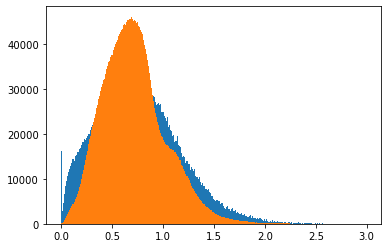

<Figure size 576x576 with 0 Axes>

In [168]:
# plt.figure(figsize=(8,8))
plt.hist(r[1].reshape(50*256*256).detach().cpu().numpy(), bins=[0.01*i for i in range(300)])
plt.hist(yhat.reshape(50*256*256).detach().cpu().numpy(), bins=[0.01*i for i in range(300)])
plt.figure(figsize=(8,8))
plt.show()

In [ ]:
# for name in modelNames:
for name in ['modelLeakyUNet_4', 'modelSimpleCNN-L_4', 'modelSimpleCNN-S_4', 'modelSimpleCNNCat_4', 'modelSimpleCNNConvT_4', 'modelSimpleCNNJules_4', 'modelSimpleCNNJulesPB_4', 'modelSimpleCNNReflect_4', 'modelUNet_4', 'model_4', 'modelUNetPrelu_4', 'modelUNetBias0_4', 'modelUNetPB_4']:
    try:
        dir = name
        os.listdir(os.path.join(PATH, "Dict", dir))[0]
        dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))
        
        diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
        diffSolv = diffSolv.to(device)
        lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict, tag='Best')
        
        yhat = diffSolv(r[0].to(device))
        
        plt.figure(figsize=(12,8))
        plt.hist(r[1].reshape(50*256*256).detach().cpu().numpy(), density=True, bins=[0.01*i for i in range(300)])
        plt.hist(yhat.reshape(50*256*256).detach().cpu().numpy(), fc=(0.5, 0.5, 0.0, 0.5), density=True, bins=[0.01*i for i in range(300)])
        plt.legend(['GT', 'Pred'])
        plt.xlabel('Field value')
        plt.ylabel(f'{name}, \n epoch = {lastEpoch}')
#         plt.show()
        
        plt.savefig(PATH + f'Figs/{name}_hist.png')
    except:
        pass

In [21]:
modelNames

['.ipynb_checkpoints',
 'model0',
 'modelLeakyUNet1',
 'modelLeakyUNet_2',
 'modelLeakyUNet_3',
 'modelLeakyUNet_4',
 'modelSimpleCNN-L1',
 'modelSimpleCNN-L_2',
 'modelSimpleCNN-L_3',
 'modelSimpleCNN-L_4',
 'modelSimpleCNN-S1',
 'modelSimpleCNN-S_2',
 'modelSimpleCNN-S_3',
 'modelSimpleCNN-S_4',
 'modelSimpleCNNCat_1',
 'modelSimpleCNNCat_2',
 'modelSimpleCNNCat_3',
 'modelSimpleCNNCat_4',
 'modelSimpleCNNConvT1',
 'modelSimpleCNNConvT_2',
 'modelSimpleCNNConvT_3',
 'modelSimpleCNNConvT_4',
 'modelSimpleCNNJules_1',
 'modelSimpleCNNJules_2',
 'modelSimpleCNNJules_3',
 'modelSimpleCNNJules_4',
 'modelSimpleCNNReflect_1',
 'modelSimpleCNNReflect_2',
 'modelSimpleCNNReflect_3',
 'modelSimpleCNNReflect_4',
 'modelUNet0',
 'modelUNet1',
 'modelUNet2',
 'modelUNetBias0_4',
 'modelUNetGPT_2',
 'modelUNetGPT_3',
 'modelUNetPrelu_4',
 'modelUNet_2',
 'modelUNet_3',
 'modelUNet_4',
 'model_2',
 'model_3',
 'model_4']

In [28]:
dir = 'modelUNetPrelu1_4'
os.listdir(os.path.join(PATH, "Dict", dir))[0]
dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))

diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
diffSolv = diffSolv.to(device)
lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict) #, tag='Best')

In [29]:
current = [diffSolv.blk1[1].weight.item(), diffSolv.blk1[3].weight.item(), 
 diffSolv.blk2[1].weight.item(), diffSolv.blk2[3].weight.item(), 
 diffSolv.blk3[1].weight.item(), diffSolv.blk3[3].weight.item(), 
 diffSolv.blk4[1].weight.item(), diffSolv.blk4[3].weight.item(),
 diffSolv.blk5[1].weight.item(), diffSolv.blk5[3].weight.item(),
 diffSolv.blkUp1[1].weight.item(), diffSolv.blkUp1[3].weight.item(), 
 diffSolv.blkUp2[1].weight.item(), diffSolv.blkUp2[3].weight.item(), 
 diffSolv.blkUp3[1].weight.item(), diffSolv.blkUp3[3].weight.item(), 
 diffSolv.blkUp4[1].weight.item(), diffSolv.blkUp4[3].weight.item(),]


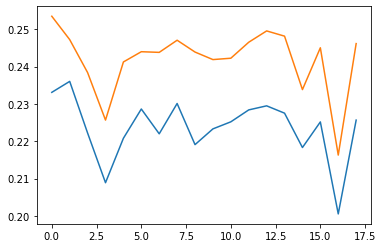

In [30]:
plt.plot(current)
plt.plot(best)

In [51]:
# Error over smaller section of lattice

10
15
20
25
30
35
40
45


In [20]:
# (r[1][1,0,:,:].numpy() - yhat[1,0,:,:].detach().cpu().numpy()) * ( (1+r[1][1,0,:,:].max()) * torch.ones_like(r[1][1,0,:,:]) - r[1][1,0,:,:]).numpy() 
dir = 'modelUNet_4'
os.listdir(os.path.join(PATH, "Dict", dir))[0]
dict = inOut().loadDict(os.path.join(PATH, "Dict", dir, os.listdir(os.path.join(PATH, "Dict", dir))[0]))

diffSolv = select_nn(dict['NN']) # DiffSur().to(device)
diffSolv = diffSolv.to(device)
lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict) #, tag='Best')

In [24]:
dd = errOverLat(diffSolv, testloader, device, transformation="linear", error_fnc=nn.MSELoss(reduction='none'))

Text(0.5, 1.0, 'UNet Last Model')

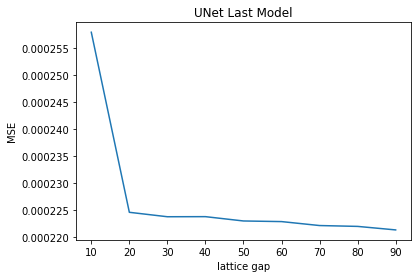

In [25]:
plt.plot(dd.keys(), [dd[key][0] for key in dd.keys()])
plt.xlabel("lattice gap")
plt.ylabel("MSE")
plt.title("UNet Last Model")

In [26]:
lastEpoch, _, diffSolv = inOut().load_model(diffSolv, "Diff", dict, tag='Best')

In [27]:
ddBest = errOverLat(diffSolv, testloader, device, transformation="linear", error_fnc=nn.MSELoss(reduction='none'))

Text(0.5, 1.0, 'UNet Best Model')

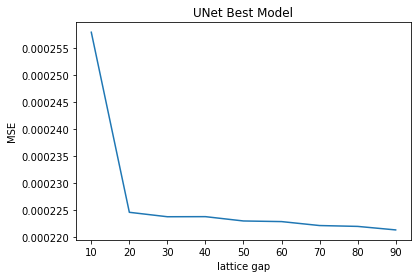

In [28]:
plt.plot(dd.keys(), [dd[key][0] for key in dd.keys()])
plt.xlabel("lattice gap")
plt.ylabel("MSE")
plt.title("UNet Best Model")